## Introduction

Switzerland is vibrant and international. Even though  migrating to Switzerland is not an easy task, it's still every ones dream to live and explore different parts of Switzerland. The aim of this capstone project is to demonstrate how Foursquare API can be used to explore and compare cities in Canton Zurich, Switzerland. This project will help people in exploring better facilities around their neighborhood in Zurich. It will help people making smart and efficient decision on selecting great neighborhood out of numbers of other neighborhoods in Zurich, Switzerland.


## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1.  <a href="#item1">Download and Explore Dataset</a>

2.  <a href="#item2">Selecting the Bezirks (Province) for Analysis</a>

3.  <a href="#item3">TASK 1: Collecting the available Restaurant data for Analysis</a>

4.  <a href="#item4">TASK 2: Analyze different Venues from each Bezirk</a>

5.  <a href="#item5">Examine Top 10 Venues in Every Bezirk and Clustering</a>  
    </font>
    </div>


Before we get the data and start exploring it, let's download all the dependencies that we will need.


In [36]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.');


Solving environment: done

# All requested packages already installed.

Libraries imported.


<a id='item1'></a>


## 1. Download and Explore Dataset


In [37]:
# Source: https://raw.githubusercontent.com/zauberware/postal-codes-json-xml-csv/master/data/CH/zipcodes.ch.csv
swiss_data = pd.read_csv('zipcodes.ch.csv')
#swiss_data.head()
print(swiss_data.shape)
swiss_data.sample(n=10)

(4356, 11)


,country_code,zipcode,place,state,state_code,province,province_code,community,community_code,latitude,longitude
505,CH,4932,Lotzwil,Canton de Berne,BE,Oberaargau,244,Lotzwil,331,47.1913,7.7910
1909,CH,6020,Emmenbrücke,Kanton Luzern,LU,Hochdorf District,313,Emmen,1024,47.0728,8.2890
2928,CH,6579,Piazzogna,Ticino,TI,Locarno District,2104,Gambarogno,5398,46.1356,8.8237
3642,CH,1658,Rossinière,Canton de Vaud,VD,Riviera-Pays-d'Enhaut District,2230,Rossinière,5842,46.4676,7.0837
4207,CH,8484,Weisslingen,Kanton Zürich,ZH,Bezirk Pfäffikon,108,Weisslingen,180,47.4306,8.7679
3019,CH,6917,Barbengo,Ticino,TI,Lugano District,2105,Lugano,5192,45.9588,8.9168
290,CH,9103,Schwellbrunn,Kanton Appenzell Ausserrhoden,AR,Bezirk Hinterland,1501,Schwellbrunn,3004,47.3525,9.2489
683,CH,3110,Münsingen,Canton de Berne,BE,Bern-Mittelland District,246,Münsingen,616,46.8730,7.5610
2160,CH,6078,Lungern,Kanton Obwalden,OW,Obwalden,600,Lungern,1405,46.7858,8.1598
298,CH,9052,Niederteufen,Kanton Appenzell Ausserrhoden,AR,Bezirk Mittelland,1502,Teufen (AR),3024,47.3940,9.3667


#### Load and explore the data


In [38]:
swiss_data["state_code"].value_counts()

BE    615
VD    464
TI    345
ZH    332
GR    325
VS    318
FR    281
AG    269
SG    223
TG    208
LU    162
SO    146
NE     93
GE     91
JU     91
BL     90
SZ     60
SH     38
GL     31
ZG     31
BS     30
AR     27
UR     27
NW     21
OW     21
AI     17
Name: state_code, dtype: int64

However, for illustration purposes, let's simplify the above map and segment and cluster only the Towns in Zurich. So let's slice the original dataframe and create a new dataframe of the Zurich data.


<AxesSubplot:xlabel='Cantons', ylabel='Number of Postal Codes'>

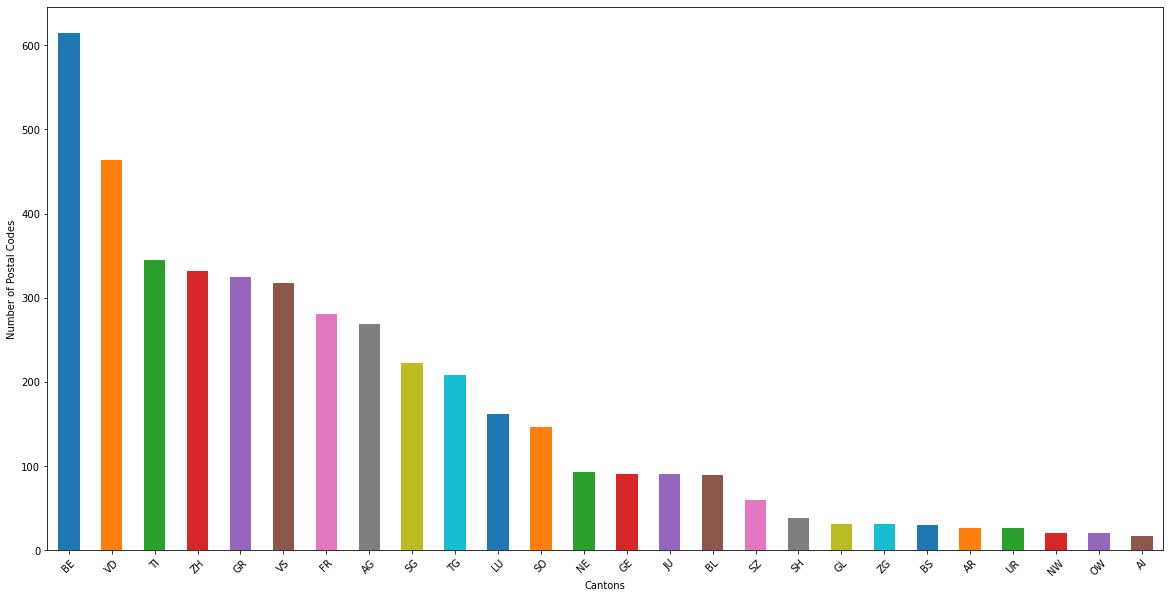

In [39]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

swiss_data["state_code"].value_counts().plot.bar(figsize=(20,10),xlabel= "Cantons",ylabel= "Number of Postal Codes",color=colors, rot=45)

In [40]:
swiss_data_ZH = swiss_data[swiss_data['state_code'].str.contains('ZH',regex=False)]
print(swiss_data_ZH.shape)
swiss_data_ZH.sample(n=10)

(332, 11)


,country_code,zipcode,place,state,state_code,province,province_code,community,community_code,latitude,longitude
4324,CH,8042,Zürich,Kanton Zürich,ZH,Bezirk Zürich,112,Zürich,261,47.3828,8.5307
4057,CH,8452,Adlikon b. Andelfingen,Kanton Zürich,ZH,Bezirk Andelfingen,102,Adlikon,21,47.5823,8.6915
4195,CH,8314,Kyburg,Kanton Zürich,ZH,Bezirk Pfäffikon,108,Illnau-Effretikon,296,47.4557,8.7448
4348,CH,8088,Zürich,Kanton Zürich,ZH,Bezirk Zürich,112,Zürich,261,47.3828,8.5307
4046,CH,8246,Langwiesen,Kanton Zürich,ZH,Bezirk Andelfingen,102,Feuerthalen,27,47.6840,8.6609
4283,CH,8543,Bertschikon,Kanton Zürich,ZH,Bezirk Winterthur,110,Wiesendangen,298,47.5273,8.8142
4199,CH,8322,Gündisau,Kanton Zürich,ZH,Bezirk Pfäffikon,108,Russikon,178,47.3984,8.8084
4261,CH,8421,Dättlikon,Kanton Zürich,ZH,Bezirk Winterthur,110,Dättlikon,215,47.5249,8.6245
4243,CH,8352,Ricketwil (Winterthur),Kanton Zürich,ZH,Bezirk Winterthur,110,Winterthur,230,47.4869,8.8006
4173,CH,8125,Zollikerberg,Kanton Zürich,ZH,Bezirk Meilen,107,Zollikon,161,47.3451,8.6009


In [41]:
swiss_data_ZH = swiss_data_ZH.reset_index()
swiss_data_ZH.head()
del swiss_data_ZH['index']

Let's get the geographical coordinates of Manhattan.


In [42]:
swiss_data_ZH.head()

,country_code,zipcode,place,state,state_code,province,province_code,community,community_code,latitude,longitude
0,CH,8143,Uetliberg,Kanton Zürich,ZH,Bezirk Affoltern,101,Stallikon,13,47.3521,8.4875
1,CH,8143,Stallikon,Kanton Zürich,ZH,Bezirk Affoltern,101,Stallikon,13,47.3258,8.4897
2,CH,8906,Bonstetten,Kanton Zürich,ZH,Bezirk Affoltern,101,Bonstetten,3,47.3150,8.4684
3,CH,8907,Wettswil,Kanton Zürich,ZH,Bezirk Affoltern,101,Wettswil am Albis,14,47.2695,8.4744
4,CH,8908,Hedingen,Kanton Zürich,ZH,Bezirk Affoltern,101,Hedingen,5,47.2979,8.4483


## Selecting the Bezirks (Province) for Analysis

In [43]:
CLIENT_ID = 'xxxxxxxxxxxx' # your Foursquare ID
CLIENT_SECRET = 'xxxxxxxxxxxx' # your Foursquare Secret
ACCESS_TOKEN = 'xxxxxxxxxxxx' # your FourSquare Access Token
VERSION = 'xxxxxxxxxxxx'
LIMIT = 50
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: xxxxxxxxxxxx
CLIENT_SECRET:xxxxxxxxxxxx


In [44]:
resList = pd.DataFrame()

In [45]:
swiss_data_ZH.head()

,country_code,zipcode,place,state,state_code,province,province_code,community,community_code,latitude,longitude
0,CH,8143,Uetliberg,Kanton Zürich,ZH,Bezirk Affoltern,101,Stallikon,13,47.3521,8.4875
1,CH,8143,Stallikon,Kanton Zürich,ZH,Bezirk Affoltern,101,Stallikon,13,47.3258,8.4897
2,CH,8906,Bonstetten,Kanton Zürich,ZH,Bezirk Affoltern,101,Bonstetten,3,47.3150,8.4684
3,CH,8907,Wettswil,Kanton Zürich,ZH,Bezirk Affoltern,101,Wettswil am Albis,14,47.2695,8.4744
4,CH,8908,Hedingen,Kanton Zürich,ZH,Bezirk Affoltern,101,Hedingen,5,47.2979,8.4483


In [46]:
resList["PLZ"] = swiss_data_ZH.zipcode
resList["Latitude"] = swiss_data_ZH.latitude
resList["Longitude"] = swiss_data_ZH.longitude
resList["Bezirk"] = swiss_data_ZH.province

In [47]:
search_query = "Restaurant"
radius= 500
print(search_query+"....OK")

resCount= []
for i in range(len(resList["Latitude"])):
    latitude_1 = resList["Latitude"].iloc[i]
    longitude_1 = resList["Longitude"].iloc[i]
    url_1 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude_1, longitude_1,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
    results_1 = requests.get(url_1).json()
    # assign relevant part of JSON to venues
    venues_1 = results_1['response']['venues']

    # tranform venues into a dataframe
    dataframe_1 = json_normalize(venues_1)
    resCount.append(len(dataframe_1))
resCount

resList["N_Restaurants"] = resCount 
resList.head()
#Now use this list of cities for the analysis
# Remove NaN, and Bar Plot and analysi on 

Restaurant....OK


KeyError: 'venues'

In [48]:
resList.shape

(332, 4)

In [49]:
#resList.to_csv(r'wholeresList.csv', index = False, header=True)
#resList_ZH = pd.read_csv('Restaurant_Zurich_dataframe.csv')
#swiss_data.head()
resList_ZH = pd.read_csv('wholeresList.csv')
print(resList_ZH.head())
resList_ZH.sample(n=10)

    PLZ  Latitude  Longitude            Bezirk  N_Restaurants
0  8143   47.3521     8.4875  Bezirk Affoltern              2
1  8143   47.3258     8.4897  Bezirk Affoltern              2
2  8906   47.3150     8.4684  Bezirk Affoltern              1
3  8907   47.2695     8.4744  Bezirk Affoltern              1
4  8908   47.2979     8.4483  Bezirk Affoltern              2


,PLZ,Latitude,Longitude,Bezirk,N_Restaurants
78,8427,47.5331,8.5845,Bezirk Bülach,1
228,8405,47.5056,8.7241,Bezirk Winterthur,8
233,8412,47.5369,8.6885,Bezirk Winterthur,0
222,8400,47.5056,8.7241,Bezirk Winterthur,8
295,8036,47.3828,8.5307,Bezirk Zürich,38
195,8121,47.3608,8.6369,Bezirk Uster,0
285,8005,47.3667,8.5500,Bezirk Zürich,29
176,8322,47.4107,8.7920,Bezirk Pfäffikon,0
80,8428,47.5512,8.5657,Bezirk Bülach,0
91,8154,47.4758,8.5190,Bezirk Dielsdorf,2


In [50]:
resList_ZH_sorted = resList_ZH.sort_values(by="N_Restaurants",ascending=False, inplace= False, kind="quicksort",na_position="last")

In [51]:
resList_ZH_sorted2 = resList_ZH_sorted.drop_duplicates(
  subset = ['Latitude', 'Longitude'],
  keep = 'last').reset_index(drop = True)

In [52]:
for i in range(len(resList_ZH_sorted2.Bezirk)):
    resList_ZH_sorted2.Bezirk.values[i] = resList_ZH_sorted2.Bezirk.values[i].strip("Bezirk ")

## Collecting the available Restaurant data for Analysis


In [53]:
resList_ZH_sorted2_filtered = resList_ZH_sorted2.drop_duplicates(
  subset = ['Bezirk'],
  keep = 'first').reset_index(drop = True)

In [54]:
selected_bezirk = resList_ZH_sorted2_filtered.head(n=12)
selected_bezirk

,PLZ,Latitude,Longitude,Bezirk,N_Restaurants
0,8086,47.3828,8.5307,Zürich,38
1,8403,47.4967,8.7342,Winterthu,18
2,8953,47.4017,8.4001,Dietikon,16
3,8302,47.4515,8.5849,ülach,12
4,8610,47.3471,8.7209,Ust,12
5,8800,47.2918,8.5635,Horgen,10
6,8623,47.3264,8.7978,Hinwil,9
7,8105,47.4341,8.4687,Dielsdorf,8
8,8910,47.2774,8.4513,Affoltern,7
9,8712,47.2425,8.7234,Meilen,5


<AxesSubplot:xlabel='Bezirks', ylabel='N_of_Restaurant'>

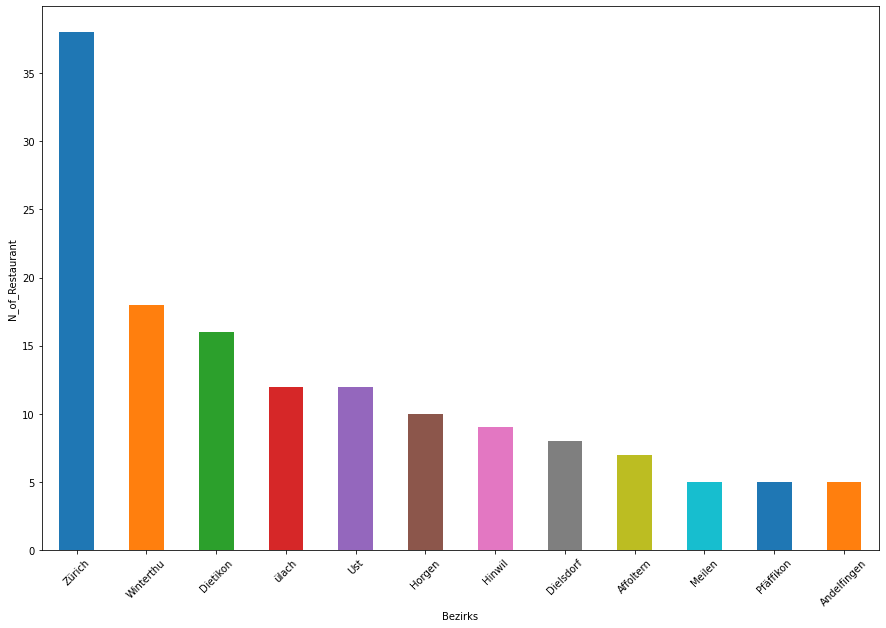

In [55]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

df2 = selected_bezirk[["Bezirk","N_Restaurants"]]
df2.plot.bar(figsize=(15,10),x= "Bezirk", y="N_Restaurants",xlabel= "Bezirks",ylabel="N_of_Restaurant",color=colors,legend=False, rot=45) 

### Now we need to pass the Lat, Long and retrieve the Ratings -- Sort them and return only the Top 5 Restaurant names Later, Plot it

#### Set the Query, URL, GET JSON

In [56]:
search_query = "Restaurant"
radius= 500
print(search_query+"....OK")

Restaurant....OK


### Latitude and Logitude of the Bezirk

In [57]:
latitude = selected_bezirk["Latitude"].iloc[0]
longitude = selected_bezirk["Longitude"].iloc[0]

### Create the URL to get JSON data

In [58]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=xxxxxxxxxxxx&client_secret=xxxxxxxxxxxx&ll=47.3828,8.5307&oauth_token=xxxxxxxxxxxx&v=xxxxxxxxxxxx&query=Restaurant&radius=500&limit=50'

### Send the Request

In [59]:
results = requests.get(url).json()

### JSON to Pandas Dataframe

In [60]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

KeyError: 'venues'

What we need from this is only the id of the restaurants -then we do the same above methods and get the rating -- sort the rating and return top 5 with info about Restaurant name, Category, Address, Lat, Long, Rating

In [61]:
# Req 1: Venue ID
venue_id = dataframe["id"].iloc[0]

NameError: name 'dataframe' is not defined

In [62]:
# Req 2: URL
url_venue = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET,ACCESS_TOKEN, VERSION)
url_venue

NameError: name 'venue_id' is not defined

In [63]:
# Now send the GET request
result_venue = requests.get(url_venue).json()

NameError: name 'url_venue' is not defined

In [64]:
#result_venue

In [65]:
#Here we take only the ratings of each location
try:
    rate = float(result_venue['response']['venue']['rating'])
    # tranform venues into a dataframe
    #dataframe = json_normalize(venues)
    print(rate)
except:
    rate = float("NaN")
    #print(result['response']['venue'])
    #print('This venue has not been rated yet.') 

In [66]:
# Function to Extract Categories
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [67]:
import copy
dataframe2 = copy.deepcopy(dataframe)
dataframe2['categories'] = dataframe2.apply(get_category_type, axis=1)
dataframe2.drop(['venuePage.id'],axis=1,inplace=True)
dataframe2.columns = [column.split('.')[-1] for column in dataframe2.columns]
dataframe2.drop(['referralId','hasPerk','address','postalCode','labeledLatLngs','distance','cc','city','state','country','formattedAddress','crossStreet','neighborhood'],axis=1,inplace=True)
dataframe2.head()

NameError: name 'dataframe' is not defined

In [68]:
import copy
#ratings= []
top5 = pd.DataFrame(columns=['id','name','categories','location.address','location.lat','location.lng','Rating'])
# 1
for Num in range(len(selected_bezirk)):
    ratings= []
    search_query = "Restaurant"
    radius= 500
    print(search_query+"....OK")

    # 2 For Each Bezirk new Lat und Long
    latitude = selected_bezirk["Latitude"].iloc[Num]
    longitude = selected_bezirk["Longitude"].iloc[Num]
    # 3 
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
    # 4
    results = requests.get(url).json()
    # 5
    # assign relevant part of JSON to venues
    venues = results['response']['venues']

    # tranform venues into a dataframe
    dataframe = json_normalize(venues)
    dataframe.head()

    # 6
    dataframe['categories'] = dataframe.apply(get_category_type, axis=1)
    dataframe = dataframe[['id','name','categories','location.address','location.lat','location.lng']]
    #dataframe.drop(['venuePage.id'],axis=1,inplace=True)
    #dataframe.columns = [column.split('.')[-1] for column in dataframe.columns]
    #dataframe.drop(['referralId','hasPerk','address','postalCode','labeledLatLngs','distance','cc','city','state','country','formattedAddress','crossStreet','neighborhood'],axis=1,inplace=True)
    #dataframe.head()

    for i in range(len(dataframe)):
        venue_id = dataframe["id"].iloc[i]
        url_venue = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET,ACCESS_TOKEN, VERSION)
        result_venue = requests.get(url_venue).json()
        try:
            rate = result_venue['response']['venue']['rating']
            #print(result_venue['response']['venue']['rating'])
        except:
            rate = float("NaN")
            #print('This venue has not been rated yet.')     
        ratings.append(rate)
    ratings

    ##
    dataframe["Rating"] = ratings

    dataframe_ratings_sorted = dataframe.sort_values(by="Rating",ascending=False, inplace= False, kind="quicksort",na_position="last")

    ##
    print("Finished Bezirk: "+str(Num)+"------")
    #print("Top 5 Restaurants in Bezirk: "+str(selected_bezirk["Bezirk"].iloc[0])+" are:") 
    #print(dataframe_ratings_sorted.head())
    top= pd.DataFrame(dataframe_ratings_sorted.head())
    #print(top)
    top5 = top5.append(top)
    
print(top5)


Restaurant....OK


KeyError: 'venues'

In [69]:
#top5.to_csv(r'top5Restaurants_whole.csv', index = False, header=True)
top5 = pd.read_csv('top5Restaurants_whole.csv')
top5.head()
#top5.drop(['Cluster Labels'],axis=1,inplace=True)
#top5.head()

,id,name,categories,location.address,location.lat,location.lng,Rating
0,4b058888f964a520f8cb22e3,Restaurant JOSEF,Swiss Restaurant,Gasometerstr. 24,47.384006,8.529020,9.0
1,4b0f01b0f964a520095e23e3,Panama Bar & Restaurant,Bar,Lettensteg 10,47.385167,8.535383,8.4
2,52dd552411d2bf369d4686a0,Restaurant & Bar Valentin's Zürich,Meyhane,Gasometerstrasse 36,47.384770,8.529928,8.4
3,4e41164662e17b948c233c11,Phuket Asia Center,Asian Restaurant,Schöneggstr. 21,47.380210,8.526542,8.0
4,4eb2f06130f85a3c6d89de74,Restaurant Valentin's,Turkish Restaurant,Gasometerstrasse 36,47.384740,8.529904,7.8


In [70]:

import folium  
from IPython.display import HTML, display
# create map of New York using latitude and longitude values
address = 'Zurich, Switzerland'

geolocator = Nominatim(user_agent="ZH_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Zurich City are {}, {}.'.format(latitude, longitude))

top5_ZH = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for name, category, address, lat, lng, ratings in zip(top5['name'],top5['categories'],top5['location.address'],top5['location.lat'],top5['location.lng'],top5['Rating']):
    label = '{}, {},{},{}'.format(name,category,address,ratings)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(top5_ZH)  
    
top5_ZH

The geograpical coordinate of Zurich City are 47.3744489, 8.5410422.


## Now try to cluster these restaurants


## Best K

In [71]:
# set number of clusters
kclusters = 3

restaurants_ZH_cluster = top5[["location.lat","location.lng"]]

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(restaurants_ZH_cluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 2, 2, 2, 2, 2], dtype=int32)

In [72]:
# add clustering labels
top5.insert(0, 'Cluster Labels', kmeans.labels_)

top5_merged = top5

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
#top5_merged = top5_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

top5_merged.head() # check the last columns!

,Cluster Labels,id,name,categories,location.address,location.lat,location.lng,Rating
0,0,4b058888f964a520f8cb22e3,Restaurant JOSEF,Swiss Restaurant,Gasometerstr. 24,47.384006,8.529020,9.0
1,0,4b0f01b0f964a520095e23e3,Panama Bar & Restaurant,Bar,Lettensteg 10,47.385167,8.535383,8.4
2,0,52dd552411d2bf369d4686a0,Restaurant & Bar Valentin's Zürich,Meyhane,Gasometerstrasse 36,47.384770,8.529928,8.4
3,0,4e41164662e17b948c233c11,Phuket Asia Center,Asian Restaurant,Schöneggstr. 21,47.380210,8.526542,8.0
4,0,4eb2f06130f85a3c6d89de74,Restaurant Valentin's,Turkish Restaurant,Gasometerstrasse 36,47.384740,8.529904,7.8


In [81]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
colors_array = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
#rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(top5_merged['location.lat'], top5_merged['location.lng'], top5_merged['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color = ['#d62728', '#9467bd','#8c564b'],
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## TASK 2: Analyze different venues from each Bezirk

In [82]:
LIMIT = 50 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

In [83]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [84]:
selected_bezirk

,PLZ,Latitude,Longitude,Bezirk,N_Restaurants
0,8086,47.3828,8.5307,Zürich,38
1,8403,47.4967,8.7342,Winterthu,18
2,8953,47.4017,8.4001,Dietikon,16
3,8302,47.4515,8.5849,ülach,12
4,8610,47.3471,8.7209,Ust,12
5,8800,47.2918,8.5635,Horgen,10
6,8623,47.3264,8.7978,Hinwil,9
7,8105,47.4341,8.4687,Dielsdorf,8
8,8910,47.2774,8.4513,Affoltern,7
9,8712,47.2425,8.7234,Meilen,5


In [85]:
bezirk_Venues = getNearbyVenues(names=selected_bezirk['Bezirk'],latitudes=selected_bezirk['Latitude'],longitudes=selected_bezirk['Longitude'])

Zürich


KeyError: 'groups'

In [86]:
#bezirk_Venues.to_csv(r'bezirk_Venues_whole.csv', index = False, header=True)
bezirk_Venues = pd.read_csv('bezirk_Venues_whole.csv')
bezirk_Venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Zürich,47.3828,8.5307,Riffraff,47.382831,8.529254,Movie Theater
1,Zürich,47.3828,8.5307,Café Noir,47.382054,8.530643,Café
2,Zürich,47.3828,8.5307,Restaurant JOSEF,47.384006,8.529020,Swiss Restaurant
3,Zürich,47.3828,8.5307,Co Chin Chin,47.383809,8.528480,Vietnamese Restaurant
4,Zürich,47.3828,8.5307,SASU Juicebar,47.382506,8.529888,Juice Bar
5,Zürich,47.3828,8.5307,Wesley's Kitchen,47.381832,8.532534,Asian Restaurant
6,Zürich,47.3828,8.5307,vineria centrale,47.382470,8.529931,Bar
7,Zürich,47.3828,8.5307,Maison Blunt,47.383721,8.528347,Moroccan Restaurant
8,Zürich,47.3828,8.5307,The International Beer Bar,47.382793,8.528632,Bar
9,Zürich,47.3828,8.5307,Lily's Stomach Supply,47.382535,8.529540,Asian Restaurant


In [87]:
print(bezirk_Venues.shape)
bezirk_Venues.head()

(155, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Zürich,47.3828,8.5307,Riffraff,47.382831,8.529254,Movie Theater
1,Zürich,47.3828,8.5307,Café Noir,47.382054,8.530643,Café
2,Zürich,47.3828,8.5307,Restaurant JOSEF,47.384006,8.529020,Swiss Restaurant
3,Zürich,47.3828,8.5307,Co Chin Chin,47.383809,8.528480,Vietnamese Restaurant
4,Zürich,47.3828,8.5307,SASU Juicebar,47.382506,8.529888,Juice Bar


In [88]:
bezirk_Venues.groupby('Neighborhood').count()
print('There are {} uniques categories.'.format(len(bezirk_Venues['Venue Category'].unique())))

There are 69 uniques categories.


<AxesSubplot:xlabel='Venue Categories', ylabel='Frequency'>

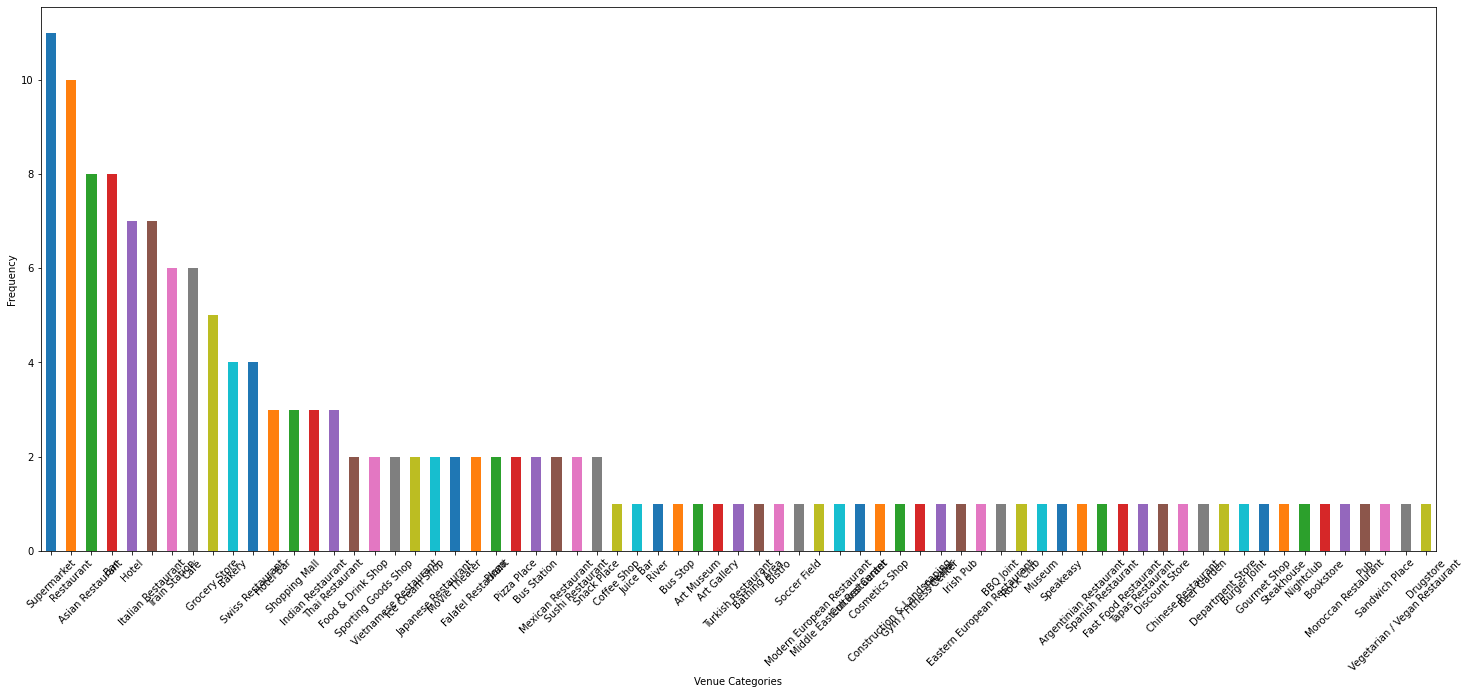

In [89]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

bezirk_Venues['Venue Category'].value_counts().plot.bar(figsize=(25,10),xlabel= "Venue Categories",ylabel= "Frequency",color=colors,rot=45)

## Wordcloud representation of Venue Categories

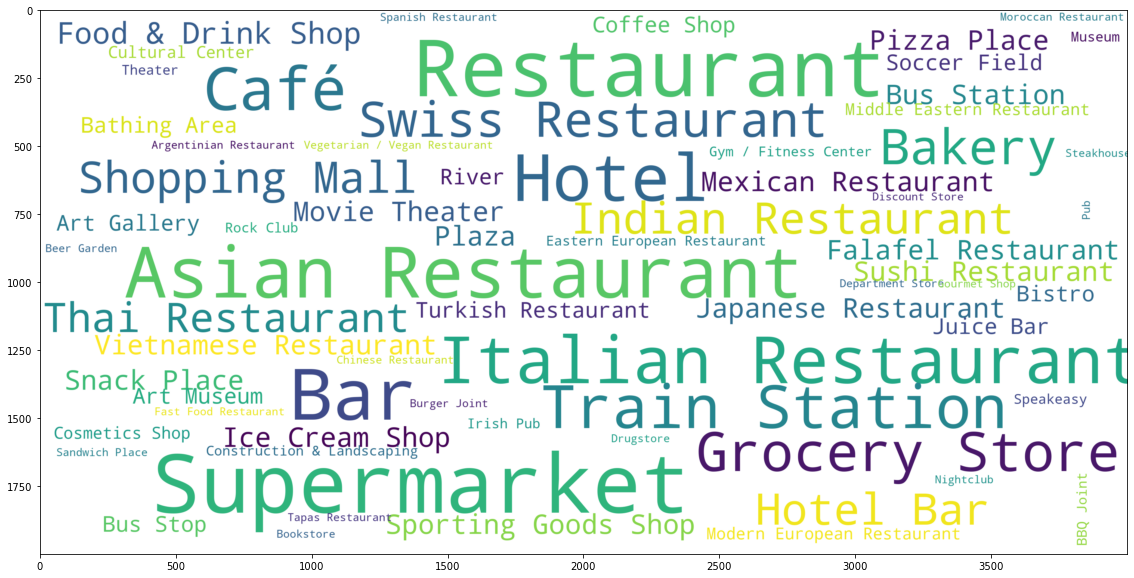

In [90]:
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

tuples = tuple([tuple(x) for x in bezirk_Venues['Venue Category'].value_counts().reset_index().values])
wordcloud = WordCloud(background_color="white",max_font_size=30, scale=10).generate_from_frequencies(dict(tuples))
plt.figure( figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")

## Analyse Each Bezirk

In [91]:
# one hot encoding
bezirk_onehot = pd.get_dummies(bezirk_Venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
bezirk_onehot['Neighborhood'] = bezirk_Venues['Neighborhood']
# move neighborhood column to the first column
fixed_columns = [bezirk_onehot.columns[-1]] + list(bezirk_onehot.columns[:-1])
bezirk_onehot = bezirk_onehot[fixed_columns]
bezirk_onehot.head()

,Neighborhood,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,BBQ Joint,Bakery,Bar,Bathing Area,Beer Garden,Bistro,Bookstore,Burger Joint,Bus Station,Bus Stop,Café,Chinese Restaurant,Coffee Shop,Construction & Landscaping,Cosmetics Shop,Cultural Center,Department Store,Discount Store,Drugstore,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,Food & Drink Shop,Gourmet Shop,Grocery Store,Gym / Fitness Center,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,Movie Theater,Museum,Nightclub,Pizza Place,Plaza,Pub,Restaurant,River,Rock Club,Sandwich Place,Shopping Mall,Snack Place,Soccer Field,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Thai Restaurant,Theater,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Zürich,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Zürich,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Zürich,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,Zürich,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,Zürich,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [92]:
bezirk_onehot.shape

(155, 70)

In [93]:
bezirk_grouped = bezirk_onehot.groupby('Neighborhood').mean().reset_index()
bezirk_grouped
bezirk_grouped.shape

(12, 70)

## Display top 10 Venues from each Bezirk

In [94]:
num_top_venues = 10

for hood in bezirk_grouped['Neighborhood']:
    #print("----"+hood+"----")
    temp = bezirk_grouped[bezirk_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

                         venue  freq
0                Grocery Store  0.14
1                   Restaurant  0.14
2                Train Station  0.14
3  Eastern European Restaurant  0.14
4                        Plaza  0.14
5             Tapas Restaurant  0.14
6                  Supermarket  0.14
7                       Museum  0.00
8                          Pub  0.00
9                  Pizza Place  0.00


            venue  freq
0   Shopping Mall  0.25
1           River  0.25
2   Train Station  0.25
3  Cosmetics Shop  0.25
4       Nightclub  0.00
5       Rock Club  0.00
6      Restaurant  0.00
7             Pub  0.00
8           Plaza  0.00
9     Pizza Place  0.00


                  venue  freq
0            Restaurant  0.18
1             Bookstore  0.09
2         Shopping Mall  0.09
3      Asian Restaurant  0.09
4         Train Station  0.09
5                 Hotel  0.09
6  Gym / Fitness Center  0.09
7           Pizza Place  0.09
8   Sporting Goods Shop  0.09
9           Supermarket  

## to pandas dataframe

In [95]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## Display 10 Venues for selected Bezirks

In [96]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
bezirk_venues_sorted = pd.DataFrame(columns=columns)
bezirk_venues_sorted['Neighborhood'] = bezirk_grouped['Neighborhood']

for ind in np.arange(bezirk_grouped.shape[0]):
    bezirk_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bezirk_grouped.iloc[ind, :], num_top_venues)

#bezirk_venues_sorted.head()
bezirk_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Affoltern,Plaza,Train Station,Grocery Store,Tapas Restaurant,Supermarket,Restaurant,Eastern European Restaurant,Vietnamese Restaurant,Discount Store,Construction & Landscaping
1,Andelfingen,Train Station,Shopping Mall,Cosmetics Shop,River,Vietnamese Restaurant,Drugstore,Construction & Landscaping,Cultural Center,Department Store,Discount Store
2,Dielsdorf,Restaurant,Gym / Fitness Center,Supermarket,Hotel,Shopping Mall,Bookstore,Pizza Place,Sporting Goods Shop,Asian Restaurant,Train Station
3,Dietikon,Supermarket,Italian Restaurant,Hotel,Bus Stop,Sushi Restaurant,Drugstore,Falafel Restaurant,Cultural Center,Department Store,Discount Store
4,Hinwil,Irish Pub,Grocery Store,Shopping Mall,Movie Theater,Supermarket,Gourmet Shop,Food & Drink Shop,Fast Food Restaurant,Falafel Restaurant,Coffee Shop
5,Horgen,Hotel,Swiss Restaurant,Falafel Restaurant,Sporting Goods Shop,Bakery,Mexican Restaurant,Asian Restaurant,Grocery Store,Train Station,Gourmet Shop
6,Meilen,Supermarket,Restaurant,Train Station,Bus Station,Eastern European Restaurant,Cosmetics Shop,Cultural Center,Department Store,Discount Store,Drugstore
7,Pfäffikon,Restaurant,Food & Drink Shop,Soccer Field,Bakery,Construction & Landscaping,Drugstore,Cosmetics Shop,Cultural Center,Department Store,Discount Store
8,Ust,Snack Place,Argentinian Restaurant,Italian Restaurant,Japanese Restaurant,Grocery Store,Fast Food Restaurant,Chinese Restaurant,Ice Cream Shop,Theater,Asian Restaurant
9,Winterthu,Café,Hotel Bar,Bar,Nightclub,Restaurant,Hotel,Burger Joint,Plaza,Swiss Restaurant,Italian Restaurant


## Cluster the Bezirks 

Run k-means to cluster the neighborhood into 3 clusters.

In [99]:
# set number of clusters
kclusters = 3

bezirk_grouped_clustering = bezirk_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bezirk_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 2, 0, 0, 2, 1, 0, 0], dtype=int32)

In [101]:
# add clustering labels
#bezirk_venues_sorted.drop(['Cluster Labels'],axis=1,inplace=True)
bezirk_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bezirk_merged = selected_bezirk ## Here we need to copy the Bezirk dataframe with Lat,Long info

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
bezirk_merged = bezirk_merged.join(bezirk_venues_sorted.set_index('Neighborhood'), on='Bezirk')

bezirk_merged.head() # check the last columns!

,PLZ,Latitude,Longitude,Bezirk,N_Restaurants,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,8086,47.3828,8.5307,Zürich,38,0,Bar,Asian Restaurant,Café,Indian Restaurant,Italian Restaurant,Vietnamese Restaurant,Thai Restaurant,Museum,Moroccan Restaurant,Modern European Restaurant
1,8403,47.4967,8.7342,Winterthu,18,0,Café,Hotel Bar,Bar,Nightclub,Restaurant,Hotel,Burger Joint,Plaza,Swiss Restaurant,Italian Restaurant
2,8953,47.4017,8.4001,Dietikon,16,2,Supermarket,Italian Restaurant,Hotel,Bus Stop,Sushi Restaurant,Drugstore,Falafel Restaurant,Cultural Center,Department Store,Discount Store
3,8302,47.4515,8.5849,ülach,12,0,Hotel,Restaurant,Supermarket,Steakhouse,Pizza Place,Pub,Department Store,Bus Station,Discount Store,Bakery
4,8610,47.3471,8.7209,Ust,12,0,Snack Place,Argentinian Restaurant,Italian Restaurant,Japanese Restaurant,Grocery Store,Fast Food Restaurant,Chinese Restaurant,Ice Cream Shop,Theater,Asian Restaurant


In [104]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bezirk_merged['Latitude'], bezirk_merged['Longitude'], bezirk_merged['Bezirk'], bezirk_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [105]:
#Cluster 0
bezirk_merged.loc[bezirk_merged['Cluster Labels'] == 0, bezirk_merged.columns[[1] + list(range(2, bezirk_merged.shape[1]))]]

,Latitude,Longitude,Bezirk,N_Restaurants,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,47.3828,8.5307,Zürich,38,0,Bar,Asian Restaurant,Café,Indian Restaurant,Italian Restaurant,Vietnamese Restaurant,Thai Restaurant,Museum,Moroccan Restaurant,Modern European Restaurant
1,47.4967,8.7342,Winterthu,18,0,Café,Hotel Bar,Bar,Nightclub,Restaurant,Hotel,Burger Joint,Plaza,Swiss Restaurant,Italian Restaurant
3,47.4515,8.5849,ülach,12,0,Hotel,Restaurant,Supermarket,Steakhouse,Pizza Place,Pub,Department Store,Bus Station,Discount Store,Bakery
4,47.3471,8.7209,Ust,12,0,Snack Place,Argentinian Restaurant,Italian Restaurant,Japanese Restaurant,Grocery Store,Fast Food Restaurant,Chinese Restaurant,Ice Cream Shop,Theater,Asian Restaurant
5,47.2918,8.5635,Horgen,10,0,Hotel,Swiss Restaurant,Falafel Restaurant,Sporting Goods Shop,Bakery,Mexican Restaurant,Asian Restaurant,Grocery Store,Train Station,Gourmet Shop
6,47.3264,8.7978,Hinwil,9,0,Irish Pub,Grocery Store,Shopping Mall,Movie Theater,Supermarket,Gourmet Shop,Food & Drink Shop,Fast Food Restaurant,Falafel Restaurant,Coffee Shop
7,47.4341,8.4687,Dielsdorf,8,0,Restaurant,Gym / Fitness Center,Supermarket,Hotel,Shopping Mall,Bookstore,Pizza Place,Sporting Goods Shop,Asian Restaurant,Train Station
8,47.2774,8.4513,Affoltern,7,0,Plaza,Train Station,Grocery Store,Tapas Restaurant,Supermarket,Restaurant,Eastern European Restaurant,Vietnamese Restaurant,Discount Store,Construction & Landscaping
11,47.6905,8.6436,Andelfingen,5,0,Train Station,Shopping Mall,Cosmetics Shop,River,Vietnamese Restaurant,Drugstore,Construction & Landscaping,Cultural Center,Department Store,Discount Store


In [106]:
#Cluster 1
bezirk_merged.loc[bezirk_merged['Cluster Labels'] == 1, bezirk_merged.columns[[1] + list(range(2, bezirk_merged.shape[1]))]]

,Latitude,Longitude,Bezirk,N_Restaurants,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,47.3878,8.7515,Pfäffikon,5,1,Restaurant,Food & Drink Shop,Soccer Field,Bakery,Construction & Landscaping,Drugstore,Cosmetics Shop,Cultural Center,Department Store,Discount Store


In [107]:
#Cluster 2
bezirk_merged.loc[bezirk_merged['Cluster Labels'] == 2, bezirk_merged.columns[[1] + list(range(2, bezirk_merged.shape[1]))]]

,Latitude,Longitude,Bezirk,N_Restaurants,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,47.4017,8.4001,Dietikon,16,2,Supermarket,Italian Restaurant,Hotel,Bus Stop,Sushi Restaurant,Drugstore,Falafel Restaurant,Cultural Center,Department Store,Discount Store
9,47.2425,8.7234,Meilen,5,2,Supermarket,Restaurant,Train Station,Bus Station,Eastern European Restaurant,Cosmetics Shop,Cultural Center,Department Store,Discount Store,Drugstore
